## Quantum Tunneling Simulation for ES 170

### This code simulates quantum mechanical tunneling of an electron across a square potential barrier. The electron is represented by a 1D Gaussian wavefunction. 1D time-dependent Schrodinger equation is solved using the finite-difference time-domain method.

#### Jupyter notebook magic commad for plotting.

In [1]:
%matplotlib notebook

#### Importing relevant python packages.

In [2]:
import numpy as np
import scipy.constants as sc
import matplotlib.pyplot as plt

#### Class for QMT FDTD. All the main variables and the fdtd update function are defined here.

In [6]:
class QMfdtd:
    def __init__(self, V0, bw, ke, sig):
        self.V0 = V0 * sc.value('electron volt')  # height of potential barrier in Joules
        self.ke = ke * sc.value('electron volt')  # kinetic energy of electron in Joules
        self.k0 = np.sqrt(self.ke * 2 * sc.m_e / (sc.hbar**2))  # wave vector of electron in m^-1
        self.bw = bw * sc.value('Angstrom star')  # potential barrier width in m
        self.sig = sig * sc.value('Angstrom star')  # Initial spread of Gaussian wavefunction
        self.dx = np.minimum((self.bw / 25.0), (self.sig / 25.0))  # grid cell size
        self.dt = 0.9 * sc.hbar / ((sc.hbar**2/(sc.m_e * self.dx**2)) + (self.V0 / 2.0))  # time step size
        length = 40 * np.maximum(self.bw, self.sig)  # length of the simulation domain
        self.ll = int(length / self.dx)  # total number of grid points in the domain
        vel = sc.hbar * self.k0 / sc.m_e
        self.tt = int(0.35 * length / vel / self.dt)  # total number of time steps in the simulation
        self.lx = np.linspace(0.0, length, self.ll)  # 1D position vector along x
        # potential barrier
        self.Vx = np.zeros(self.ll)
        bwgrid = int(self.bw/(2.0 * self.dx))
        bposgrid = int(self.ll/2.0)
        bl = bposgrid - bwgrid
        br = bposgrid + bwgrid
        self.Vx[bl:br] = self.V0
        # wavefunction arrays
        self.psir = np.zeros((self.ll))
        self.psii = np.zeros((self.ll))
        self.psimag = np.zeros(self.ll)
        ac = 1.0 / np.sqrt((np.sqrt(np.pi)) * self.sig)
        x0 = bl * self.dx - 6 * self.sig
        psigauss = ac * np.exp(-(self.lx - x0)**2 / (2.0 * self.sig**2))
        self.psir = psigauss * np.cos(self.k0 * self.lx)
        self.psii = psigauss * np.sin(self.k0 * self.lx)
        self.psimag = self.psir**2 + self.psii**2
        # fdtd update coefficients
        self.c1 = sc.hbar * self.dt / (2.0 * sc.m_e * self.dx**2)
        self.c2 = self.dt / sc.hbar
        
#### The main FDTD update function.

    def fdtd_update(self):
        self.psii[1:self.ll - 1] = (self.c1 * (self.psir[2:self.ll] - 2.0 * self.psir[1:self.ll - 1]
                                    + self.psir[0:self.ll - 2]) 
                                    - self.c2 * self.Vx[1:self.ll - 1] * self.psir[1:self.ll - 1]
                                    + self.psii[1:self.ll - 1])
        self.psir[1:self.ll - 1] = (-self.c1 * (self.psii[2:self.ll] - 2.0 * self.psii[1:self.ll - 1]
                                    + self.psii[0:self.ll - 2]) 
                                    + self.c2 * self.Vx[1:self.ll - 1] * self.psii[1:self.ll - 1]
                                    + self.psir[1:self.ll - 1])
        self.psimag = self.psir**2 + self.psii**2

#### Function that defines the run routine and plots

In [7]:
def run_sim(V0_in, bw_in, ke_in, sig_in):
    q1 = QMfdtd(V0_in, bw_in, ke_in, sig_in)
    print('')
    print('Potential barrier =', round(q1.V0 / sc.value('electron volt'), 2), 'eV')
    print('Potential barrier width =', round(q1.bw / sc.value('Angstrom star'), 2), 'A')
    print('(The boundary of the simulation domain is assumed to be an infinite barrier)')
    print('Electron energy =', round(q1.ke / sc.value('electron volt'), 2), 'eV')
    print('Electron spread =', round(q1.sig / sc.value('Angstrom star'), 2), 'A')
    print('')
    print('Grid size =', '%.2e' % (q1.dx / sc.value('Angstrom star')), 'A')
    print('Time step =', "%.2e" % (q1.dt * 1e15), 'fs')
    plt.ion()
    fig0 = plt.figure()
    ax0 = fig0.add_subplot(111)
    ax0.set_xlabel('position ($\AA$)')
    ax0.set_ylabel('$\Psi$')
    ax0.set_title('Initial wavefunctions (normalized)')
    ax0.plot(q1.lx / sc.value('Angstrom star'), q1.psimag / np.amax(q1.psimag), label='$|\Psi|^2$')
    ax0.plot(q1.lx / sc.value('Angstrom star'), q1.Vx / np.amax(q1.Vx), label='barrier')
    ax0.plot(q1.lx / sc.value('Angstrom star'), q1.psii / np.amax(q1.psii), label='$\Im[\Psi]$', alpha=0.5)
    ax0.plot(q1.lx / sc.value('Angstrom star'), q1.psir / np.amax(q1.psir), label='$\Re[\Psi]$', alpha=0.5)
    ax0.legend()
    fig0.show()
    fig0.tight_layout()
    fig0.canvas.draw()
    input('Press enter to start the simulation...')
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111)
    ax1.set_xlabel('position ($\AA$)')
    ax1.set_ylabel('norm magnitude')
    fig1.show()
    fig1.canvas.draw()
    for nn in range(0, q1.tt):
        q1.fdtd_update()
        if nn % 50 == 0:
            tstr = 'Time = ' + str(round(nn * q1.dt * 1e15, 4)) + ' fs'
            ax1.clear()
            ax1.plot(q1.lx / sc.value('Angstrom star'), q1.psimag / np.amax(q1.psimag), label='$|\Psi|^2$')
            ax1.plot(q1.lx / sc.value('Angstrom star'), q1.Vx / np.amax(q1.Vx), label='barrier')
            ax1.legend()
            ax1.set_title(tstr)
            ax1.set_xlabel('position ($\AA$)')
            ax1.set_ylabel('normalized magnitude')
            fig1.canvas.draw()
    fig2 = plt.figure()
    ax2 = fig2.add_subplot(111)
    ax2.set_xlabel('position ($\AA$)')
    ax2.set_ylabel('$\Psi$')
    ax2.set_title('Final wavefunctions (normalized)')
    ax2.plot(q1.lx / sc.value('Angstrom star'), q1.psimag / np.amax(q1.psimag), label='$|\Psi|^2$')
    ax2.plot(q1.lx / sc.value('Angstrom star'), q1.Vx / np.amax(q1.Vx), label='barrier')
    ax2.plot(q1.lx / sc.value('Angstrom star'), q1.psii / np.amax(q1.psii), label='$\Im[\Psi]$', alpha=0.5)
    ax2.plot(q1.lx / sc.value('Angstrom star'), q1.psir / np.amax(q1.psir), label='$\Re[\Psi]$', alpha=0.5)
    ax2.legend()
    fig2.show()
    fig2.tight_layout()
    fig2.canvas.draw()

#### Ask for user input and run the simulation. The user can input the barier height and width, electron energy and initial spread.


Enter the barrier height in eV (try 600): 0
Enter the barrier width in Angstrom (try 0.25): 0.25
Enter the electron energy in eV (try 500): 500
Enter the initial electron wavefunction spread in Angstrom (try 0.8): 0.8

Potential barrier = 0.0 eV
Potential barrier width = 0.25 A
(The boundary of the simulation domain is assumed to be an infinite barrier)
Electron energy = 500.0 eV
Electron spread = 0.8 A

Grid size = 1.00e-02 A
Time step = 7.77e-06 fs


<IPython.core.display.Javascript object>


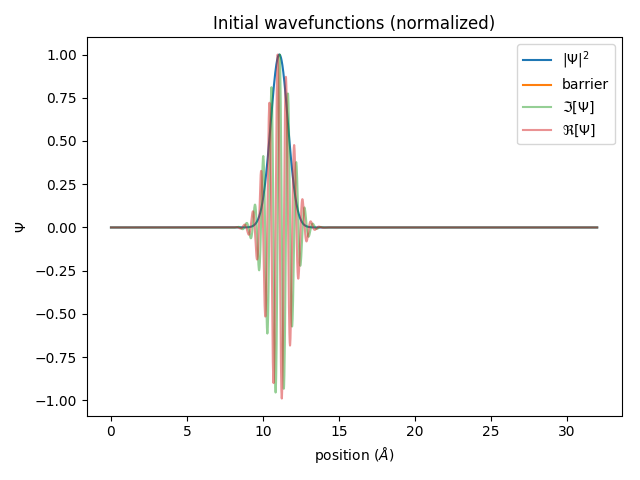

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


Press enter to start the simulation...


<IPython.core.display.Javascript object>

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


In [ ]:
print('')
V0_in = float(input('Enter the barrier height in eV (try 600): '))
bw_in = float(input('Enter the barrier width in Angstrom (try 0.25): '))
ke_in = float(input('Enter the electron energy in eV (try 500): '))
sig_in = float(input('Enter the initial electron wavefunction spread in Angstrom (try 0.8): '))
run_sim(V0_in, bw_in, ke_in, sig_in)